### 1.定义工具

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 定义 Tavily 搜索工具，最大搜索结果数设置为 2
tool = TavilySearchResults(max_results=2)
tools = [tool]

# 测试工具调用
# tool.invoke("What's a 'node' in LangGraph?")

### 2.绑定工具

In [5]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

# 定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 初始化 LLM 并绑定搜索工具
chat_model = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = chat_model.bind_tools(tools)

# 更新聊天机器人节点函数，支持工具调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 将更新后的节点添加到状态图中
graph_builder.add_node("chatbot", chatbot)

### 3.创建一个工具运行函数
一个类，包含所有工具。根据大模型返回结果，统一处理工具调用。我们通过向图中添加一个新节点来实现这一点。


In [6]:
import json
from langchain_core.messages import ToolMessage

# 定义 BasicToolNode，用于执行工具请求
class BasicToolNode:
    """一个在最后一条 AIMessage 中执行工具请求的节点。
    
    该节点会检查最后一条 AI 消息中的工具调用请求，并依次执行这些工具调用。
    """

    def __init__(self, tools: list) -> None:
        # tools 是一个包含所有可用工具的列表，我们将其转化为字典，
        # 通过工具名称（tool.name）来访问具体的工具
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """执行工具调用
        
        参数:
        inputs: 包含 "messages" 键的字典，"messages" 是对话消息的列表，
                其中最后一条消息可能包含工具调用的请求。
        
        返回:
        包含工具调用结果的消息列表
        """
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")

        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
        # 返回包含工具调用结果的消息
        return {"messages": outputs}

In [7]:
# 将 BasicToolNode 添加到状态图中
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### 4. 添加条件边

In [8]:
from typing import Literal

# 定义路由函数，检查工具调用
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return "__end__"  # 否则返回 "__end__"，流程结束

# 添加条件边，判断是否需要调用工具
graph_builder.add_conditional_edges(
    "chatbot",  # 从聊天机器人节点开始
    route_tools,  # 路由函数，决定下一个节点
    {
        "tools": "tools", 
        "__end__": "__end__"
    },  # 定义条件的输出，工具调用走 "tools"，否则走 "__end__"
)

# 当工具调用完成后，返回到聊天机器人节点以继续对话
graph_builder.add_edge("tools", "chatbot")

# 指定从 START 节点开始，进入聊天机器人节点
graph_builder.add_edge(START, "chatbot")

### 5. 编译可视化

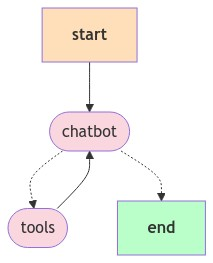

In [9]:
# 编译状态图，生成可执行的流程图
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


### 6.调用执行

In [10]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)


Assistant: 
Assistant: [{"url": "https://zhuanlan.zhihu.com/p/620529542", "content": "\u5982\u4f55\u4f7f\u7528 LangChain\uff1f\n\u8981\u4f7f\u7528 LangChain\uff0c\u5f00\u53d1\u4eba\u5458\u9996\u5148\u8981\u5bfc\u5165\u5fc5\u8981\u7684\u7ec4\u4ef6\u548c\u5de5\u5177\uff0c\u4f8b\u5982 LLMs, chat models, agents, chains, \u5185\u5b58\u529f\u80fd\u3002\u8fd9\u4e9b\u7ec4\u4ef6\u7ec4\u5408\u8d77\u6765\u521b\u5efa\u4e00\u4e2a\u53ef\u4ee5\u7406\u89e3\u3001\u5904\u7406\u548c\u54cd\u5e94\u7528\u6237\u8f93\u5165\u7684\u5e94\u7528\u7a0b\u5e8f\u3002\nLangChain \u4e3a\u7279\u5b9a\u7528\u4f8b\u63d0\u4f9b\u4e86\u591a\u79cd\u7ec4\u4ef6\uff0c\u4f8b\u5982\u4e2a\u4eba\u52a9\u7406\u3001\u6587\u6863\u95ee\u7b54\u3001\u804a\u5929\u673a\u5668\u4eba\u3001\u67e5\u8be2\u8868\u683c\u6570\u636e\u3001\u4e0e API \u4ea4\u4e92\u3001\u63d0\u53d6\u3001\u8bc4\u4f30\u548c\u6c47\u603b\u3002\nWhat\u2019s a LangChain model?\nLangChain model \u662f\u4e00\u79cd\u62bd\u8c61\uff0c\u8868\u793a\u6846\u67b6\u4e2d\u4f7f\u7528\u7684\u4

KeyboardInterrupt: Interrupted by user